<center><img src='https://drive.google.com/uc?export=view&id=1qJ8NqAZolTBQY7lN-deZ8xEsU3dlUiLz' width=200></center>


<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Cours XAI</center>
    <center> Activités 2 : Explications post-hoc sur images</center>
<hr style=" border:none; height:3px;">
</h1>

Dans ce notebook, nous allons nous intéresser à des modèles type "Réseaux de neurones" et utiliser quelques outils pour les interpréter post-hoc.

# Prérequis

En plus des modules que nous avons déjà installé, vous aurez besoin des modules suivants: keras, tensorflow.

Notez que tensorflow ne fonctionne pas avec python 3.9. Cependant, vous pouvez installer une version non-stable avec tf-nightly.

# Chargement d'un modèle pré-entraîné

Nous allons utiliser Keras et le modèle [inception v3](http://arxiv.org/abs/1512.00567). Il s'agit d'un CNN spécialisé dans la reconnaissance d'objets. Nous vous donnons également une petite fonction qui permet de mettre au bon format une image.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3

from keras import preprocessing
import keras.applications
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


model= tf.keras.applications.inception_v3.InceptionV3()
#model = inception_v3.InceptionV3()

def preprocess_img_list(liste):
    """Prend une liste de chaines de caractères représentant les paths des images à charger 
       et retourne une collection d'objets utilisables par le CNN"""
    out = []
    for img_path in liste:
       # img = image.load_img(img_path, target_size=(299, 299))
        
        image = tf.keras.utils.load_img(img_path,target_size=(299, 299))
        x = tf.keras.utils.img_to_array(image)
        #img = load_img(img_path, target_size=(299, 299))
        #x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = tf.keras.applications.inception_v3.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

def show(img):
    """Affiche une image prétraitée"""
    plt.imshow(img / 2 + 0.5)

## Prise en main du modèle

Affichez la description de `model`en appelant sa méthode `summary`.

In [2]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

Pré-traitez l'image `image1.jpg` et affichez-la avec les méthodes `preprocess_img_list` et `show` déclarées ci-dessus. 
Ensuite, utilisez la méthode `predict` de `model` en lui donnant le résultat de `preprocess_img_list` et stockez les prédictions dans une variable (`preds` par exemple).

En utlisant `decode_predictions(preds)`, vous obtiendez une énumération des classes pour chacune des images que vous pouvez parcourir avec un `for`. Affichez les prédictions pour cette image.

35363/35363 [==============================] - 0s 0us/step
('n02437312', 'Arabian_camel', 0.95046294)
('n02437616', 'llama', 0.0014278524)
('n02917067', 'bullet_train', 0.0010896112)
('n04243546', 'slot', 0.00044309814)
('n04067472', 'reel', 0.00038128896)


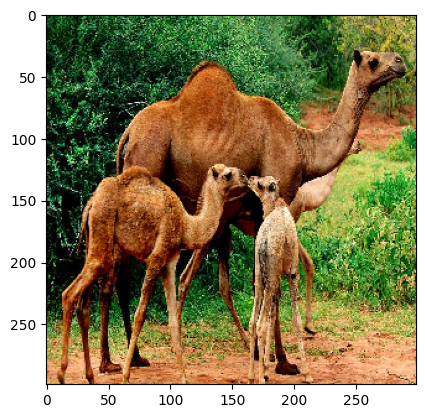

In [3]:
images = preprocess_img_list(['image1.jpg'])
show(images[0])
preds = model.predict(images)

for x in tf.keras.applications.inception_v3.decode_predictions(
    preds)[0]:
    print(x)

# LIME

Dans cette partie, nous allons appliquer LIME à cette image. LIME va nous donner pour chacune des classes les pixels qui ont conduit à cette décision.

## Obtention de l'explication
Créez un `LimeImageExplainer`.
Utilisez sa méthode `explain_instance` pour obtenir l'explication. Cette méthode prend pour arguments:
* l'image, qu'il faut convertir en tableau de double avec `images[0].astype('double')`
* la méthode `predict` de `model`

Il faudra ensuite fournir les paramètres optionnels suivants:
* `top_labels`: indique combien de classes il faut considérer
* `hide_color`: couleur utilisée pour les pixels qui ne font pas partie de l'explication. Mettez 0 (gris) 
* `num_samples`: combien d'échantillons vont être générés par LIME. Attention, comme il s'agit d'images, ça va être long...

In [4]:
!pip install lime

In [5]:
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


## Affichage de l'explication

A présent, vous avez l'explication et il faut l'afficher. Pour cela, utilisez la méthode `get_image_and_mask` de `explanation` qui prend en argument obligatoire:
* la classe concernée: typiquement, on lui passe `explanation.top_labels[i]` où i est la ième top classe.

Puis, en argument optionnel:
* `positive_only`: un booléen qui indique si l'on veut afficher uniquement les pixels qui expliquent positivement la classe. En général, on met True
* `num_features`: indique le nombre de superpixels qui s'afficheront
* `hide_rest`: booléen qui indique que la partie non explicative de l'image soit grisée. Générallement, False.

Cette fonction retourne deux résultats: un résultat intermédiaire et un masque.
On vous donne une fonction qui affiche l'image résultat et qui prend `temp`et `mask` en paramètres.

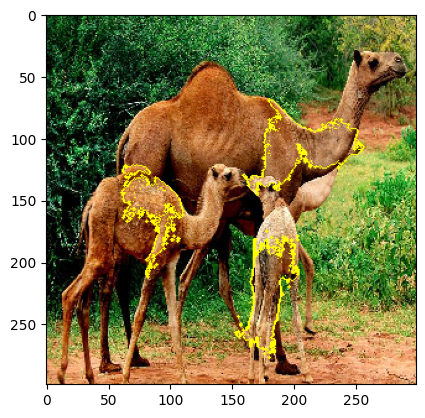

In [6]:
from skimage.segmentation import mark_boundaries

def show(temps, mask):
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

show(temp, mask)

## Interprétation

Testez sur les différentes classes détectées. Interprétez les résultats.

In [7]:
#Interprétez ici dans une string """ """

# GradCAM

GradCAM est une autre méthode pour connaître l'importance des pixels d'une image dans la prise de décision. Pour rappel, elle utilise la dernière couche convolutionnelle d'un CNN.

Nous allons vous guider pas à pas dans l'implémentation de GradCAM. En effet, il n'y a pas d'implémentation bien packagée (ou il y a un conflit de version de scipy entre LIME et GradCAM, etc.). 

Le tutoriel de base est [ici](https://keras.io/examples/vision/grad_cam/).

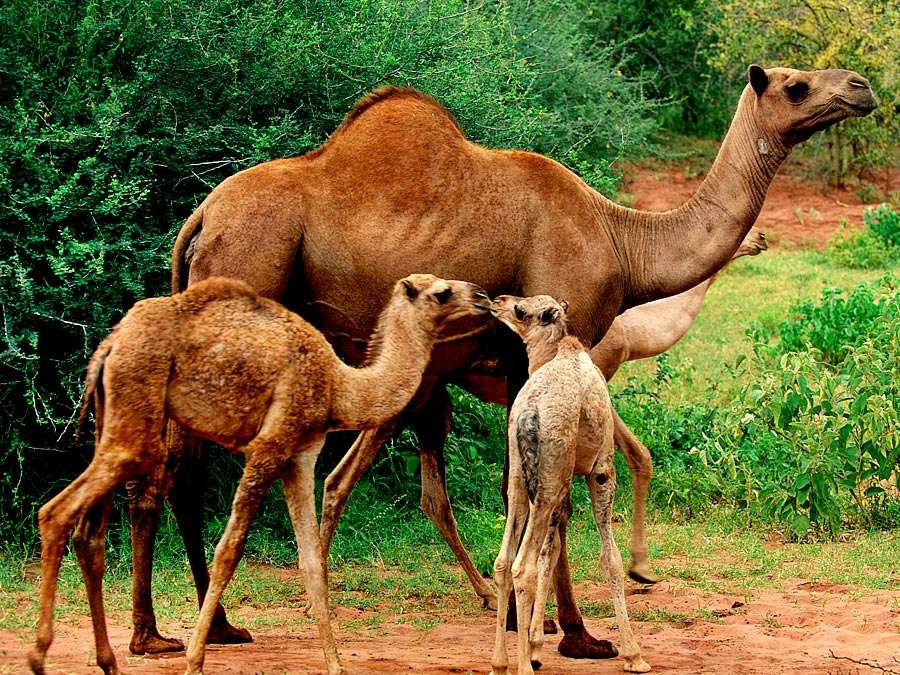

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Méthodes d'affichage
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# On définit ici des constantes et des raccourcis de méthodes
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# image à traiter
img_path = "image1.jpg"

display(Image(img_path))

Vous devez donner ici le nom exact de la dernière couche de convolution. Utilisez l'inspection du modèle plus haut.

In [9]:
last_conv_layer_name = "block14_sepconv2_act"

On va créer une méthode qui formatte correctement notre image. Pour cela, on va utiliser :
- keras.preprocessing.image.load_img pour charger l'image à la bonne taille. On obtient ainsi une image PIL
- keras.preprocessing.image.img_to_array qui prend l'image PIL et la transforme en un numpy array de float32 de taille (299, 299, 3)
- np.expand_dims pour créer un numpy array de dimension (1, 299, 299, 3)

In [10]:
def get_img_array(img_path, size):
    """ 
        From an image path and the size (299x299 for inception 3), gets an array of one image.
    """
    
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


Voici la fonction qui calcule la heatmap. Elle n'est pas simple à écrire, il faut lire l'article entier pour pouvoir l'implémenter.

In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # On crée dans un premier temps un modèle qui mappe l'image d'entrée
    # et les activations de la dernière couche de convolution
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Puis on calcule le gradient des top classes pour l'image d'entrée
    # en fonction des gradients de la dernière couche de convolution
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Ceci correspond au gradient du neurone de sortie (top classe)
    # en fonction de la feature map de sortie de la dernière couche de convolution.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Tableau dont chaque cellule est l'intensté moyenne du gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # On multiplie chaque cellule du tableau 
    # par "combien cette cellule est importante" par rapport à la top classe
    # et on somme tout pour obtenir la heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Pour faciliter la visualisation on normalise la heatmap entre 0 et 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

A présent, on va exploiter les méthodes définies ci-dessus.

In [12]:
# Appeler preprocess_input sur notre image avec la bonne taille (constante définie au-dessus)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# On récupère le modèle
model = model_builder(weights="imagenet")

# On supprime le softmax de la dernière couche
model.layers[-1].activation = None

# Affiche la top classe
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Calcule de la heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


1/1 [==============================] - 1s 1s/step
Predicted: [('n02437312', 'Arabian_camel', 10.673281)]


On écrit et on appelle une fonction pour faire un joli affichage.

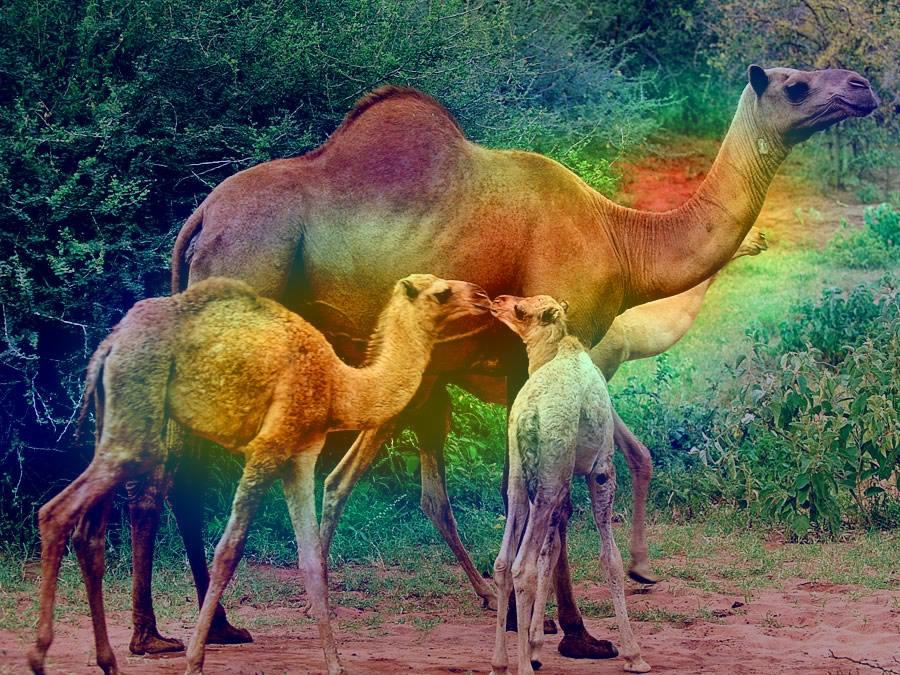

In [13]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)